## Assignment #1 - Volume and taper estimation

### Part 0 - VOLLIB setup and data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vol_eqs import VollibWrapper
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# IMPORTANT: Update this path to your vollib DLL location
DLL_PATH = r"S:/projects/Fall2025/ForestAnalytics/ForestAnalytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll"

print("=== Forest Inventory Analysis Using VOLLIB ===")
print("Analysis of Lubrecht Experimental Forest Plot 9\n")

# Initialize the VOLLIB wrapper
try:
    vol_estimator = VollibWrapper(dll_path=DLL_PATH)
    print("✓ VOLLIB DLL loaded successfully")
except Exception as e:
    print(f"✗ Error loading VOLLIB DLL: {e}")
    print("Please update the DLL_PATH variable to match your system")
    raise

# Load the plot data from Excel file
try:
    plot_data = pd.read_excel('lef_plot9.xlsx', sheet_name=0)  # First sheet
    species_codes = pd.read_csv('fia_treenames.csv')
    plot_data = plot_data.merge(species_codes[['FIA Code', 'Common Name']], left_on='SPCD', right_on='FIA Code', how='left')
    plot_data.rename(columns={'Common Name': 'SpeciesName'}, inplace=True)
    print("Plot data loaded successfully")
    print(f"Dataset contains {len(plot_data)} trees")
except FileNotFoundError:
    print("Excel file 'lef_plot9.xlsx' not found")

=== Forest Inventory Analysis Using VOLLIB ===
Analysis of Lubrecht Experimental Forest Plot 9

✓ VOLLIB DLL loaded successfully
Plot data loaded successfully
Dataset contains 33 trees


In [16]:
tree24 = plot_data[plot_data['TreeID'] == 24].iloc[0]

tree_params = {
    "region": 1, "forest": "16", "district": "01",
    "species_code": 122,
    "dbh": 5.9, "height": 38, "crown_ratio": 0.4,
}

vol_estimator._get_volume_equation(tree_params['region'], tree_params['forest'], tree_params['district'], tree_params['species_code'], eq_type='biomass')
vol_estimator.calc_carbon_content(**tree_params, eq_type='biomass')

61.85334396362305

### Part 1 - Tree 24 measurements

In [12]:
tree24 = plot_data[plot_data['TreeID'] == 24].iloc[0]

print(f"\nTree 24 Characteristics:")
print(f"Species: {tree24['SpeciesName']} (Code: {tree24['SPCD']})")
print(f"DBH: {tree24['DBH']:.1f} inches")
print(f"Total Height: {tree24['TotHeight']:.1f} feet")

tree_params = {
    "region": 1, "forest": "16", "district": "01",
    "species_code": int(tree24['SPCD']),
    "dbh": tree24['DBH'], "height": tree24['TotHeight'],
}

try:
    total_cuft = vol_estimator.calc_total_cubic_ft(**tree_params)
    merch_cuft = vol_estimator.calc_merch_cubic_ft(**tree_params, merch_top_dib_primary=4.0)
    
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)
    
    print(f"\nVolume Calculations for Tree 24:")
    print(f"Basal Area: {basal_area:.3f} sq ft")
    print(f"Total Cubic Volume: {total_cuft:.2f} cu ft")
    print(f"Merchantable Volume (4\" top): {merch_cuft:.2f} cu ft")
    
    tree_params_temp = tree_params.copy()
    # remove dbh and height for equation retrieval
    tree_params_temp.pop('dbh')
    tree_params_temp.pop('height')
    voleq = vol_estimator._get_volume_equation(**tree_params_temp)
    
except Exception as e:
    print(f"Error in volume calculations: {e}")
    total_cuft = merch_cuft = 0
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)

print(f"\nEquation Description:")
print(f"The specific equation chosen was {voleq}.")


Tree 24 Characteristics:
Species: western larch (Code: 73)
DBH: 17.9 inches
Total Height: 107.0 feet

Volume Calculations for Tree 24:
Basal Area: 1.748 sq ft
Total Cubic Volume: 63.70 cu ft
Merchantable Volume (4" top): 57.70 cu ft

Equation Description:
The specific equation chosen was I00FW2W073.


This equation is selected based on the species, region, and forest type of the tree, where I00 is the INGY model for region wide application, FW2 is Flewelling's 2 point profile model (uses DBH and total height), W is the western region, and 073 is the FIA Species code (SPCD).

### Part 2 - Tree 24 taper profile


Taper Profile Data (first 10 points):
 height_ft    dob_in    dib_in
       1.0 22.874405 17.886278
       2.0 20.609877 16.685486
       3.0 19.215843 15.924394
       4.0 18.265102 15.396261
       5.0 17.564985 15.009604
       6.0 17.083824 14.715923
       7.0 16.730036 14.486467
       8.0 16.454094 14.302851
       9.0 16.229458 14.152652
      10.0 16.042849 14.027126

Girard Form Class: 75.1


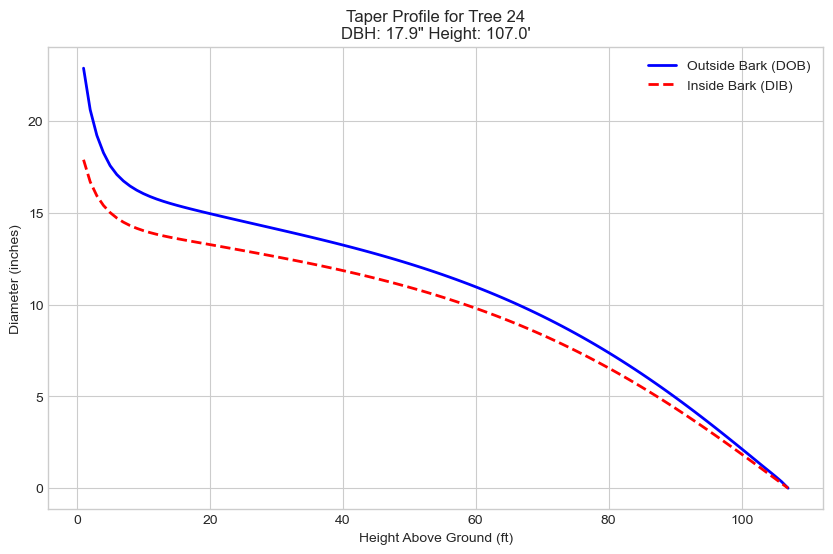

In [6]:
full_report = vol_estimator.get_full_report(**tree_params)
taper_data = full_report['taper_data']

print(f"\nTaper Profile Data (first 10 points):")
print(taper_data.head(10).to_string(index=False))
dib_17_3 = np.interp(17.3, taper_data['height_ft'], taper_data['dib_in'])
gfc = (dib_17_3 / tree24['DBH']) * 100
print(f"\nGirard Form Class: {gfc:.1f}")

plt.figure(figsize=(10, 6))
plt.plot(taper_data['height_ft'], taper_data['dob_in'], 
         'b-', linewidth=2, label='Outside Bark (DOB)')
plt.plot(taper_data['height_ft'], taper_data['dib_in'], 
         'r--', linewidth=2, label='Inside Bark (DIB)')
plt.xlabel('Height Above Ground (ft)')
plt.ylabel('Diameter (inches)')
plt.title(f'Taper Profile for Tree 24\nDBH: {tree24["DBH"]:.1f}" Height: {tree24["TotHeight"]:.1f}\'')
plt.legend()
plt.show()

### Part 3 - Alternate tree type

Comparing Tree 24 if it were an Engelmann spruce instead of a Douglas-fir.

Volume Comparison:
              Metric Douglas-fir Engelmann spruce
Total Volume (cu ft)       63.70            75.40
Merch Volume (cu ft)       57.70            67.50


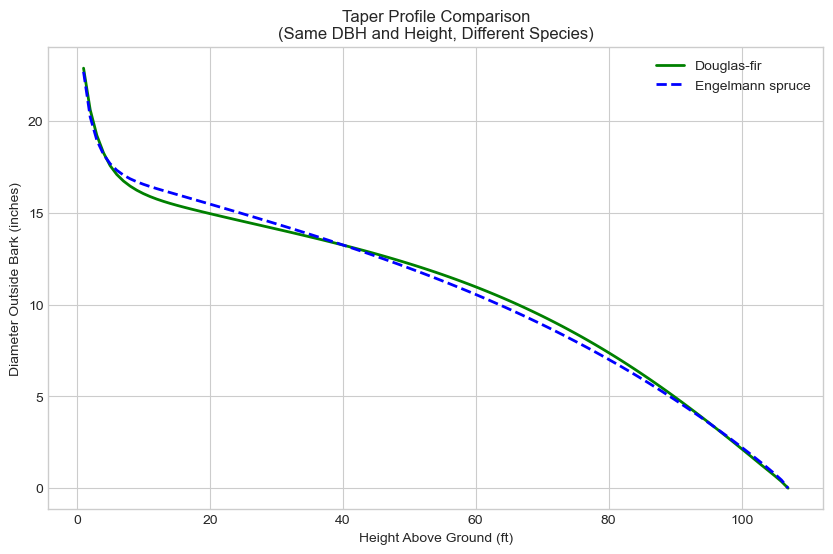

In [13]:
print("Comparing Tree 24 if it were an Engelmann spruce instead of a Douglas-fir.")

es_params = tree_params.copy()
es_params['species_code'] = 93  # Engelmann Spruce FIA code

es_total_cuft = vol_estimator.calc_total_cubic_ft(**es_params)
es_merch_cuft = vol_estimator.calc_merch_cubic_ft(**es_params, merch_top_dib_primary=4.0)

comparison_df = pd.DataFrame({
    'Metric': ['Total Volume (cu ft)', 'Merch Volume (cu ft)'],
    'Douglas-fir': [f"{total_cuft:.2f}", f"{merch_cuft:.2f}"],
    'Engelmann spruce': [f"{es_total_cuft:.2f}", f"{es_merch_cuft:.2f}"]
})
print("\nVolume Comparison:")
print(comparison_df.to_string(index=False))
df_taper = vol_estimator.get_full_report(**tree_params)['taper_data']
es_taper = vol_estimator.get_full_report(**es_params)['taper_data']

if not df_taper.empty and not es_taper.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(df_taper['height_ft'], df_taper['dob_in'], 
             'g-', linewidth=2, label='Douglas-fir')
    plt.plot(es_taper['height_ft'], es_taper['dob_in'], 
             'b--', linewidth=2, label='Engelmann spruce')
    plt.xlabel('Height Above Ground (ft)')
    plt.ylabel('Diameter Outside Bark (inches)')
    plt.title('Taper Profile Comparison\n(Same DBH and Height, Different Species)')
    plt.legend()
    plt.show()

Species difference explanation:

Different tree species have different shapes, wood densities, and growth patterns, which affect their volume and taper profiles. In this example comparing Douglas-fir to Englemann spruce, the Douglas-fir typically has a more pronounced taper, which leads to less volume than the Englemann spruce for the same DBH and height.

### Part 4 - All tree measurements

In [ ]:
live_trees = plot_data[(plot_data['Status'] == 1) & (plot_data['DBH'] >= 5.0)].copy()

print(f"Analyzing {len(live_trees)} live trees ≥ 5\" DBH")

def calculate_tree_volumes(row):
    """Calculates volumes and BA for a single tree row."""
    try:
        params = {
            "region": 1, "forest": "16", "district": "01",
            "species_code": int(row['SPCD']),
            "dbh": row['DBH'], "height": row['TotHeight'],
        }
        params_temp = params.copy()
        # remove dbh and height for equation retrieval
        params_temp.pop('dbh', None)
        params_temp.pop('height', None)
        voleq = vol_estimator._get_volume_equation(**params_temp)
        total_vol = vol_estimator.calc_total_cubic_ft(**params)
        merch_vol = vol_estimator.calc_merch_cubic_ft(**params, merch_top_dib_primary=4.0)
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        
        return pd.Series({
            'basalAreasqft': basal_area, 'totVol': total_vol,
            'merchVol': merch_vol, 'volEQnum': voleq
        })
    except Exception:
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        return pd.Series({
            'basalAreasqft': basal_area, 'totVol': 0,
            'merchVol': 0, 'volEQnum': 'Error'
        })

volume_results = live_trees.apply(calculate_tree_volumes, axis=1)
live_trees = pd.concat([live_trees, volume_results], axis=1)

display_cols = ['TreeID', 'SpeciesName', 'DBH', 'TotHeight', 
                'basalAreasqft', 'totVol', 'merchVol', 'volEQnum']
print(f"\nTree-Level Results:")
print(live_trees[display_cols].round(2).to_string())

Analyzing 29 live trees ≥ 5" DBH

Tree-Level Results:
    TreeID    SpeciesName   DBH  TotHeight  basalAreasqft  totVol  merchVol    volEQnum
0        1  western larch   8.0       61.0           0.35     8.0       6.5  I00FW2W073
1        2  western larch  16.1       93.0           1.41    45.3      42.3  I00FW2W073
2        3    Douglas-fir   7.3       34.0           0.29     3.8       2.3  I00FW2W202
3        4    Douglas-fir  15.8       88.0           1.36    42.9      40.4  I00FW2W202
4        5    Douglas-fir   8.4       68.0           0.38    10.4       8.4  I00FW2W202
5        6  western larch   7.1       68.0           0.27     7.3       5.4  I00FW2W073
6        7  western larch   7.8       78.0           0.33    10.2       8.2  I00FW2W073
7        8  western larch   8.6       71.0           0.40    10.9       9.1  I00FW2W073
8        9  western larch   8.6       82.0           0.40    12.8      11.1  I00FW2W073
9       10    Douglas-fir   8.4       55.0           0.38     8.3 

### Part 5 - Aggregate plot-level statistics

Plot Summary (Per-Acre Basis):
Plot Size: 0.1002 acres (expansion factor: 10.0)
Total Basal Area: 193.84486558350397 sq ft/acre
Total Volume: 5856 cu ft/acre
Merchantable Volume: 5197 cu ft/acre

Merchantable Volume by DBH Class and Species (cu ft/acre):
SpeciesName  Douglas-fir  western larch
DBH_Class                              
5-7                 38.9           69.9
7-9                234.5          445.1
9-11                76.8          563.9
11-13                0.0          199.6
13-15                0.0         1294.4
15-17              403.2          844.3
17-19                0.0         1025.9


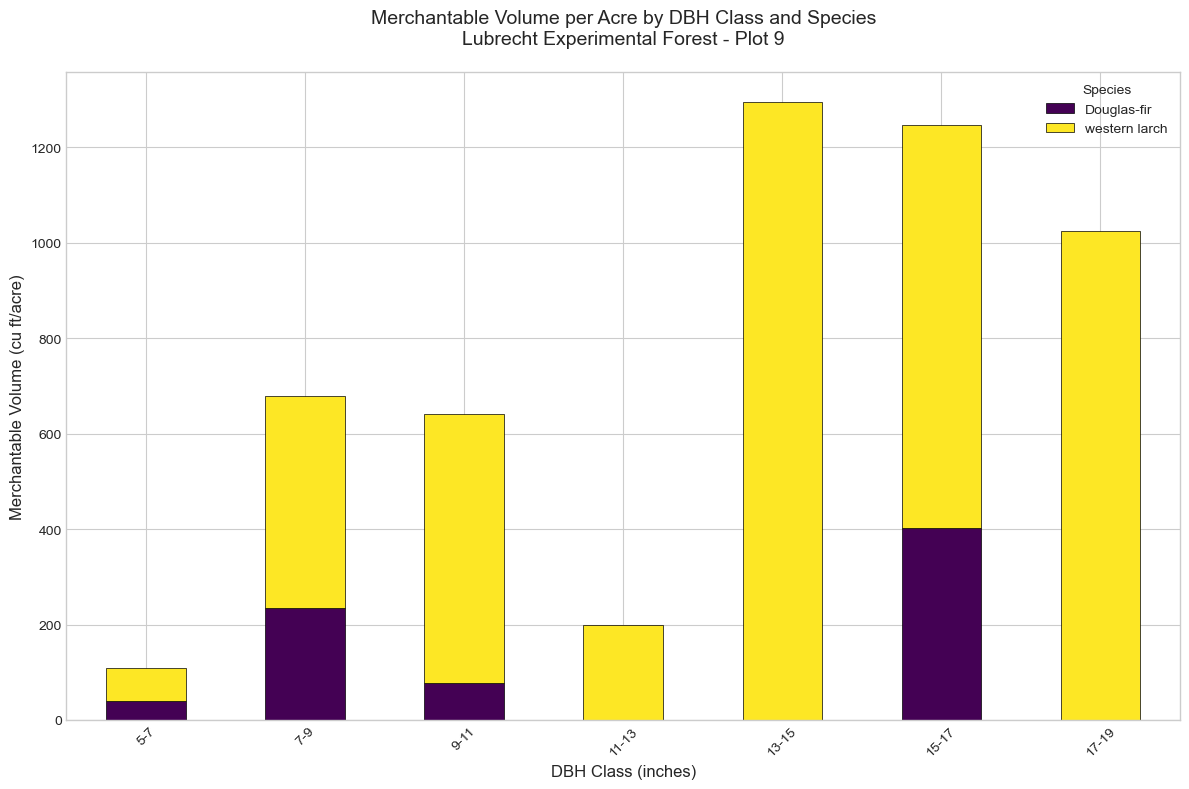

In [15]:
plot_size_acres = 1/9.98  # For trees ≥ 5" DBH
expansion_factor = 1 / plot_size_acres

total_ba_per_acre = live_trees['basalAreasqft'].sum() * expansion_factor
total_vol_per_acre = live_trees['totVol'].sum() * expansion_factor
merch_vol_per_acre = live_trees['merchVol'].sum() * expansion_factor

print(f"Plot Summary (Per-Acre Basis):")
print(f"Plot Size: {plot_size_acres:.4f} acres (expansion factor: {expansion_factor:.1f})")
print(f"Total Basal Area: {total_ba_per_acre} sq ft/acre")
print(f"Total Volume: {total_vol_per_acre:.0f} cu ft/acre")
print(f"Merchantable Volume: {merch_vol_per_acre:.0f} cu ft/acre")

# Create DBH classes for histogram
dbh_min = 5
dbh_max = int(np.ceil(live_trees['DBH'].max()))
bin_width = 2
bins = list(range(dbh_min, dbh_max + bin_width + 1, bin_width))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

live_trees['DBH_Class'] = pd.cut(live_trees['DBH'], bins=bins, labels=labels, right=False)
live_trees['merchVol_per_acre'] = live_trees['merchVol'] * expansion_factor

volume_by_class_species = live_trees.pivot_table(
    index='DBH_Class', columns='SpeciesName', 
    values='merchVol_per_acre', aggfunc='sum', fill_value=0
)

print(f"\nMerchantable Volume by DBH Class and Species (cu ft/acre):")
print(volume_by_class_species.round(1))

volume_by_class_species.plot(
    kind='bar', stacked=True, figsize=(12, 8),
    colormap='viridis', edgecolor='black', linewidth=0.5)

plt.title('Merchantable Volume per Acre by DBH Class and Species\nLubrecht Experimental Forest - Plot 9', 
          fontsize=14, pad=20)
plt.xlabel('DBH Class (inches)', fontsize=12)
plt.ylabel('Merchantable Volume (cu ft/acre)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.tight_layout()
plt.show()